# EDA


## Summary

- Preprocessing
  - cols_null_all = ["fullscreen", "hq", "music"]
- CV Strategy
  - GroupKFold
    - Group=session_id
  - level_groupは極端な偏りがあるわけではなさそうなので調整しない
- Feature Engineering
  - level_groupで特徴量を分けず、session_idごとにlevel_groupを横断した特徴を作る
    - 学習データを分けないことでモデルが横断した特徴を学習させたほうがいい気がする（←edaでなにか確かめられる？）


In [37]:
import sys

sys.path.append("../src/")

In [38]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
input_dir = pathlib.Path("../data/raw")

train = pd.read_csv(input_dir / "train.csv")
train_labels = pd.read_csv(input_dir / "train_labels.csv")
test = pd.read_csv(input_dir / "test.csv")
sample_submission = pd.read_csv(input_dir / "sample_submission.csv")

In [40]:
dfs = {
    "train": train,
    "train_labels": train_labels,
    "test": test,
    "sample_submission": sample_submission,
}


for name, df in dfs.items():
    print("\n\n===", name, "===")
    print(df.shape)
    display(df.head())
    print(df.info())



=== train ===
(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      float64
 17  hq              float64
 18  music           float64
 19  level_group     object 
dtypes: float64(9), int64(4), object(7)
memory usage: 2.0+ GB
None


=== train_labels ===
(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1
3,20090314363702160_q1,1
4,20090314441803444_q1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212022 entries, 0 to 212021
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   session_id  212022 non-null  object
 1   correct     212022 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ MB
None


=== test ===
(3728, 21)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
0,20090109393214576,0,0,cutscene_click,basic,0,NaN,-413.991405,75.685314,380.0,...,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4,20090109393214576_0-4
1,20090109393214576,1,1965,person_click,basic,0,NaN,-105.991405,-63.314686,688.0,...,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090109393214576_0-4
2,20090109393214576,2,3614,person_click,basic,0,NaN,-418.991405,47.685314,375.0,...,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090109393214576_0-4
3,20090109393214576,3,5330,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,...,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090109393214576_0-4
4,20090109393214576,4,6397,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,...,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4,20090109393214576_0-4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3728 entries, 0 to 3727
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   session_id      3728 non-null   int64  
 1   index           3728 non-null   int64  
 2   elapsed_time    3728 non-null   int64  
 3   event_name      3728 non-null   object 
 4   name            3728 non-null   object 
 5   level           3728 non-null   int64  
 6   page            153 non-null    float64
 7   room_coor_x     3366 non-null   float64
 8   room_coor_y     3366 non-null   float64
 9   screen_coor_x   3366 non-null   float64
 10  screen_coor_y   3366 non-null   float64
 11  hover_duration  353 non-null    float64
 12  text            1162 non-null   object 
 13  fqid            2505 non-null   object 
 14  room_fqid       3728 non-null   object 
 15  text_fqid       1162 non-null   object 
 16  fullscreen      0 non-null      float64
 17  hq              0 non-null      f

,session_id,correct,session_level
0,20090109393214576_q1,0,20090109393214576_0-4
1,20090312143683264_q1,0,20090312143683264_0-4
2,20090312331414616_q1,0,20090312331414616_0-4
3,20090109393214576_q2,0,20090109393214576_0-4
4,20090312143683264_q2,0,20090312143683264_0-4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   session_id     54 non-null     object
 1   correct        54 non-null     int64 
 2   session_level  54 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.4+ KB
None


### カラムの意味

- session_id - イベントが発生したセッションのID
- index - セッション内でのイベントのインデックス
- elapsed_time - セッションの開始からイベントの記録までに経過した時間（ミリ秒単位）
- event_name - イベントの種類の名前
- name - イベント名（例えば、ノートブックをクリックしたのが開くか閉じるかを識別する）
- level - イベントが発生したゲームのレベル（0から22）
- page - イベントのページ番号（ノートブック関連のイベントのみ）
- room_coor_x - クリックした場所のゲーム内の部屋に対する座標（クリックイベントのみ）
- room_coor_y - クリックした場所のゲーム内の部屋に対する座標（クリックイベントのみ）
- screen_coor_x - クリックした場所のプレイヤーの画面に対する座標（クリックイベントのみ）
- screen_coor_y - クリックした場所のプレイヤーの画面に対する座標（クリックイベントのみ）
- hover_duration - ホバーイベントが発生した時間（ミリ秒単位）（ホバーイベントのみ）
- text - プレイヤーがこのイベントで見たテキスト
- fqid - イベントの完全修飾ID
- room_fqid - イベントが発生した部屋の完全修飾ID
- text_fqid - イベントに関連するテキストの完全修飾ID
- fullscreen - プレイヤーがフルスクリーンモードかどうか
- hq - ゲームが高品質モードかどうか
- music - ゲームの音楽がオンかオフか
- level_group - この行が属するレベルグループ（および質問グループ）（0-4、5-12、13-22）

## Todo memo

- カテゴリと数字データは分けて分析したいね
  - train, testでカテゴリデータは網羅されていると思ってよい？ない場合はnullで補完する必要がある
- 予測対象のユーザはユニーク？
- 特徴量はグループごとに作成し、0-4の特徴量でq_id in(0,1,2,3,4)を予測する？

## Num Unique session_id

In [41]:
train_labels.rename(columns={"session_id": "session_q_id"}, inplace=True)
sample_submission.rename(columns={"session_id": "session_q_id"}, inplace=True)

In [42]:
train["session_q_id"] = train["session_id"].astype(str) + "_q" + train["level"].astype(str)
test["session_q_id"] = test["session_id"].astype(str) + "_q" + test["level"].astype(str)

In [43]:
train_labels = train_labels.assign(
    level=train_labels["session_q_id"].apply(lambda x: x.split('_')[1][-1]).astype(int),
    session_id=train_labels["session_q_id"].apply(lambda x: x.split('_')[0])
)
sample_submission = sample_submission.assign(
    level=sample_submission["session_q_id"].apply(lambda x: x.split('_')[1][-1]).astype(int),
    session_id=sample_submission["session_q_id"].apply(lambda x: x.split('_')[0])
)

In [44]:
dfs = {
    "train": train,
    "train_labels": train_labels,
    "test": test,
    "sample_submission": sample_submission,
}

for name, df in dfs.items():
    print("\n\n===", name, "===")
    print("NUnique session id:", df["session_id"].nunique())
    
    print("NUnique session q id:", df["session_q_id"].nunique())
    print("NUnique session q id:", sorted(df["level"].unique()))



=== train ===
NUnique session id: 11779
NUnique session q id: 270626
NUnique session q id: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


=== train_labels ===
NUnique session id: 11779
NUnique session q id: 212022
NUnique session q id: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


=== test ===
NUnique session id: 3
NUnique session q id: 69
NUnique session q id: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


=== sample_submission ===
NUnique session id: 3
NUnique session q id: 54
NUnique session q id: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [48]:
# NOTE: Unique session ids each level group. 
for name, df in [("Train", train), ("Test", test)]:
    print(name)
    for lg, gdf in df.groupby("level_group"):
        print(lg, ">>>", gdf["session_id"].nunique())

Train
0-4 >>> 11779
13-22 >>> 11779
5-12 >>> 11779
Test
0-4 >>> 3
13-22 >>> 3
5-12 >>> 3


## Check for duplicate session_id

In [45]:
train_session_ids = set(train["session_id"].unique())
test_session_ids = set(test["session_id"].unique())

In [46]:
print("Duplicate session ids:", len(train_session_ids) - len(train_session_ids - test_session_ids))

Duplicate session ids: 0


重複はないので、評価時もsession_idで排他的にする必要がありそう


## Demo test timeseries api

private lbで評価されるデータ量はtrainと同じくらいの量がある

In [47]:
level_groups = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for level_group, level_range in level_groups.items():
    test_iter = test.query("level_group==@level_group")
    print("NUnique session q id:", sorted(test_iter["level"].unique()))

NUnique session q id: [0, 1, 2, 3, 4]
NUnique session q id: [5, 6, 7, 8, 9, 10, 11, 12]
NUnique session q id: [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


## Null values

In [49]:
train.isnull().mean()

session_id        0.000000
index             0.000000
elapsed_time      0.000000
event_name        0.000000
name              0.000000
level             0.000000
page              0.978386
room_coor_x       0.078657
room_coor_y       0.078657
screen_coor_x     0.078657
screen_coor_y     0.078657
hover_duration    0.924038
text              0.635129
fqid              0.315742
room_fqid         0.000000
text_fqid         0.635125
fullscreen        1.000000
hq                1.000000
music             1.000000
level_group       0.000000
session_q_id      0.000000
dtype: float64

In [50]:
# NOTE: 上記より、以下のカラムは全てnull
cols_null_all = ["fullscreen", "hq", "music"]

## Categorical and numeric

- event_name
  - 数も多すぎず、特徴量になりそう
- name
  - 同じく特徴量になりそう
- text
  - event_nameに対する付加情報になりうるが、前処理のコストが高そう
- fqid
  - ちょっとよくわからんが2%以下はothersとして、カテゴリ変数として使うのがよさそう
- room_fqid
  - ３つの要素に分割してカテゴリ変数にする
  - １つ目のブロックは単一の値しか取らないので無視する
- text_fqid
  - 内容が複雑っぽい
  - text同様に前処理のコストが高いかも？
- level_qid
  - 特徴量に入れる？
  - もしかしたらモデルを分けたほうが予測速度が早い？

In [51]:
cols_cat = [
    "event_name",
    "name",
    "text",
    "fqid",
    "room_fqid",
    "room_fqid_0",
    "room_fqid_1",
    "room_fqid_2",
    "text_fqid",
    "level_group",
]
cols_num = [
    "elapsed_time",
    "level",
    "page",
    "room_coor_x",
    "room_coor_y",
    "screen_coor_x",
    "screen_coor_y",
    "hover_duration",
    "fullscreen",
    "hq",
    "music",
]

### Categorical

In [52]:
train[[f"room_fqid_{i}" for i in range(3)]] = train["room_fqid"].str.split(".", expand=True)
test[[f"room_fqid_{i}" for i in range(3)]] = test["room_fqid"].str.split(".", expand=True)

In [53]:
train[cols_cat].describe(include="O")

,event_name,name,text,fqid,room_fqid,room_fqid_0,room_fqid_1,room_fqid_2,text_fqid,level_group
count,13174211,13174211,4806891,9014563,13174211,13174211,13174211,13174211,4806945,13174211
unique,11,6,594,127,19,1,10,13,126,3
top,navigate_click,undefined,undefined,worker,tunic.historicalsociety.entry,tunic,historicalsociety,frontdesk,tunic.historicalsociety.cage.confrontation,13-22
freq,5687896,6377305,178294,939555,1816202,13174211,7376226,3202252,333363,6746397


In [54]:
for c in cols_cat:
    print(c, ">>>")
    display(train[c].value_counts(normalize=True).sort_values(ascending=False).head(10))
    display(train[c].value_counts(normalize=True).sort_values(ascending=True).head(10))

event_name >>>


navigate_click        0.431745
person_click          0.229604
cutscene_click        0.102604
object_click          0.083471
object_hover          0.040163
map_hover             0.035799
notification_click    0.024602
notebook_click        0.021614
map_click             0.019638
observation_click     0.008066
Name: event_name, dtype: float64

checkpoint            0.002695
observation_click     0.008066
map_click             0.019638
notebook_click        0.021614
notification_click    0.024602
map_hover             0.035799
object_hover          0.040163
object_click          0.083471
cutscene_click        0.102604
person_click          0.229604
Name: event_name, dtype: float64

name >>>


undefined    0.484075
basic        0.480030
close        0.025739
open         0.008966
prev         0.000746
next         0.000443
Name: name, dtype: float64

next         0.000443
prev         0.000746
open         0.008966
close        0.025739
basic        0.480030
undefined    0.484075
Name: name, dtype: float64

text >>>


undefined                                                    0.037091
\u00f0\u0178\u02dc\u0090                                     0.005073
Hey!                                                         0.004935
I should go to the Capitol and tell Mrs. M!                  0.004176
This is perfect for the exhibit.                             0.004158
Look at all those activists!                                 0.004158
If I were you, I'd go to the library and do some digging.    0.004052
Ugh. Fine.                                                   0.003743
\u00f0\u0178\u02dc\u00b4                                     0.003709
You can talk to a textile expert there.                      0.003668
Name: text, dtype: float64

Meet me back in my office and we'll get started!    2.080347e-07
Sounds good, Boss.                                  2.080347e-07
Why don't you prove your case?                      2.080347e-07
It'll be okay, Jo. We'll find Teddy!                2.080347e-07
Nice work on the shirt, Jolie!                      2.080347e-07
Leopold, can you run back to the museum?            2.080347e-07
Come on, Jo!                                        2.080347e-07
Jo, meet me back at my office.                      2.080347e-07
I hope you find your badger, kid.                   2.080347e-07
Thanks!                                             2.080347e-07
Name: text, dtype: float64

fqid >>>


worker           0.104226
archivist        0.062483
gramps           0.062233
wells            0.043733
toentry          0.043510
confrontation    0.038684
crane_ranger     0.027948
groupconvo       0.025279
flag_girl        0.024933
tomap            0.022428
Name: fqid, dtype: float64

block_1                         0.000003
fox                             0.000018
block_badge_2                   0.000056
need_glasses                    0.000075
block_badge                     0.000095
block_tomap1                    0.000098
journals_flag.pic_2_old.next    0.000110
block_nelson                    0.000122
block_tocollection              0.000122
journals_flag.pic_1_old.next    0.000142
Name: fqid, dtype: float64

room_fqid >>>


tunic.historicalsociety.entry           0.137860
tunic.wildlife.center                   0.114685
tunic.historicalsociety.cage            0.089447
tunic.library.frontdesk                 0.081623
tunic.historicalsociety.frontdesk       0.073798
tunic.historicalsociety.stacks          0.068366
tunic.historicalsociety.closet_dirty    0.059821
tunic.humanecology.frontdesk            0.050299
tunic.historicalsociety.basement        0.044409
tunic.kohlcenter.halloffame             0.041580
Name: room_fqid, dtype: float64

tunic.capitol_2.hall                       0.012295
tunic.capitol_0.hall                       0.015839
tunic.capitol_1.hall                       0.016987
tunic.historicalsociety.collection_flag    0.017232
tunic.flaghouse.entry                      0.031648
tunic.historicalsociety.closet             0.032628
tunic.historicalsociety.collection         0.036336
tunic.drycleaner.frontdesk                 0.037349
tunic.library.microfiche                   0.037795
tunic.kohlcenter.halloffame                0.041580
Name: room_fqid, dtype: float64

room_fqid_0 >>>


tunic    1.0
Name: room_fqid_0, dtype: float64

tunic    1.0
Name: room_fqid_0, dtype: float64

room_fqid_1 >>>


historicalsociety    0.559899
library              0.119419
wildlife             0.114685
humanecology         0.050299
kohlcenter           0.041580
drycleaner           0.037349
flaghouse            0.031648
capitol_1            0.016987
capitol_0            0.015839
capitol_2            0.012295
Name: room_fqid_1, dtype: float64

capitol_2            0.012295
capitol_0            0.015839
capitol_1            0.016987
flaghouse            0.031648
drycleaner           0.037349
kohlcenter           0.041580
humanecology         0.050299
wildlife             0.114685
library              0.119419
historicalsociety    0.559899
Name: room_fqid_1, dtype: float64

room_fqid_2 >>>


frontdesk       0.243070
entry           0.169509
center          0.114685
cage            0.089447
stacks          0.068366
closet_dirty    0.059821
hall            0.045121
basement        0.044409
halloffame      0.041580
microfiche      0.037795
Name: room_fqid_2, dtype: float64

collection_flag    0.017232
closet             0.032628
collection         0.036336
microfiche         0.037795
halloffame         0.041580
basement           0.044409
hall               0.045121
closet_dirty       0.059821
stacks             0.068366
cage               0.089447
Name: room_fqid_2, dtype: float64

text_fqid >>>


tunic.historicalsociety.cage.confrontation                           0.069350
tunic.wildlife.center.crane_ranger.crane                             0.048964
tunic.historicalsociety.frontdesk.archivist.newspaper                0.044651
tunic.historicalsociety.entry.groupconvo                             0.044434
tunic.wildlife.center.wells.nodeer                                   0.041602
tunic.historicalsociety.frontdesk.archivist.have_glass               0.041034
tunic.drycleaner.frontdesk.worker.hub                                0.037710
tunic.historicalsociety.closet_dirty.gramps.news                     0.034759
tunic.humanecology.frontdesk.worker.intro                            0.031173
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation    0.027383
Name: text_fqid, dtype: float64

tunic.drycleaner.frontdesk.block_1          6.240970e-07
tunic.humanecology.frontdesk.block_1        1.664259e-06
tunic.historicalsociety.entry.gramps.hub    4.368679e-06
tunic.drycleaner.frontdesk.block_0          2.205143e-05
tunic.wildlife.center.fox.concern           2.309159e-05
tunic.capitol_2.hall.chap4_finale_c         3.390927e-05
tunic.capitol_1.hall.chap2_finale_c         3.682172e-05
tunic.capitol_0.hall.chap1_finale_c         5.117595e-05
tunic.kohlcenter.halloffame.block_0         5.138399e-05
tunic.library.frontdesk.block_badge_2       5.159202e-05
Name: text_fqid, dtype: float64

level_group >>>


13-22    0.512091
5-12     0.336500
0-4      0.151408
Name: level_group, dtype: float64

0-4      0.151408
5-12     0.336500
13-22    0.512091
Name: level_group, dtype: float64

### Numeric


- elapsed_time
  - 一番重要な特徴量になりそう
- level
  - 重要そう
- page
  - null rateが高いのでdrop
- room, screen_xy
  - これはそのまま特徴量にしてみる

In [55]:
train[cols_num].describe(include="number")

,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
count,1.317421e+07,1.317421e+07,284746.000000,1.213797e+07,1.213797e+07,1.213797e+07,1.213797e+07,1.000737e+06,0.0,0.0,0.0
mean,3.846817e+06,1.219194e+01,3.157930,-5.493615e+01,-1.162997e+02,4.581144e+02,3.852363e+02,3.186237e+03,NaN,NaN,NaN
std,2.701387e+07,6.499188e+00,2.064042,5.201468e+02,2.185912e+02,2.472144e+02,1.292879e+02,3.692265e+05,NaN,NaN,NaN
min,0.000000e+00,0.000000e+00,0.000000,-1.992355e+03,-9.181587e+02,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
25%,4.394300e+05,6.000000e+00,1.000000,-3.529376e+02,-2.128361e+02,2.690000e+02,3.040000e+02,1.000000e+02,NaN,NaN,NaN
50%,1.013425e+06,1.300000e+01,3.000000,-1.116317e+01,-9.778151e+01,4.470000e+02,3.970000e+02,4.180000e+02,NaN,NaN,NaN
75%,1.740050e+06,1.800000e+01,5.000000,2.963618e+02,2.268531e+01,6.630000e+02,4.710000e+02,1.266000e+03,NaN,NaN,NaN
max,1.749293e+09,2.200000e+01,6.000000,1.261774e+03,5.436164e+02,1.916000e+03,1.439000e+03,2.199078e+08,NaN,NaN,NaN


In [56]:
train[cols_num].isnull().mean()

elapsed_time      0.000000
level             0.000000
page              0.978386
room_coor_x       0.078657
room_coor_y       0.078657
screen_coor_x     0.078657
screen_coor_y     0.078657
hover_duration    0.924038
fullscreen        1.000000
hq                1.000000
music             1.000000
dtype: float64

<AxesSubplot:ylabel='Frequency'>

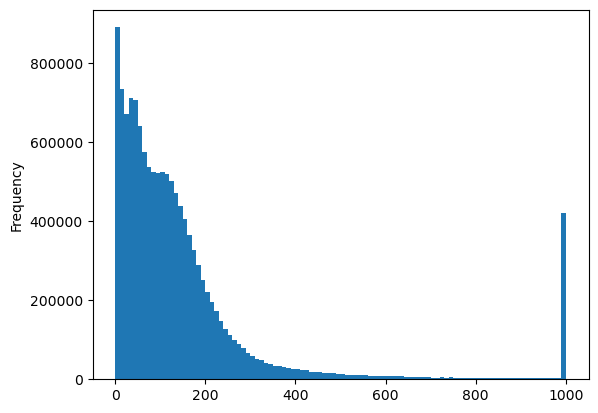

In [57]:
# NOTE: elapsed_timeはclip(0, 1e7)にする
train = train.assign(elapsed_time=lambda x: x["elapsed_time"].clip(0, 1e7) / 10000.0)
train.query("elapsed_time <= 1e7")["elapsed_time"].plot(kind="hist", bins=100, xlabel="elapsed_time")

<AxesSubplot:xlabel='level', ylabel='count'>

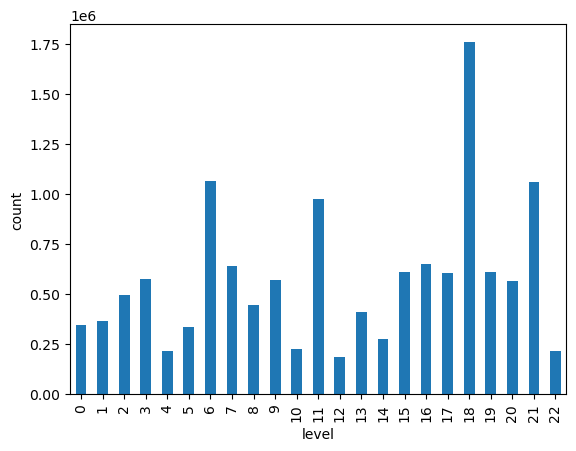

In [58]:
train["level"].value_counts().sort_index().plot(kind="bar", xlabel="level", ylabel="count")

<AxesSubplot:ylabel='Frequency'>

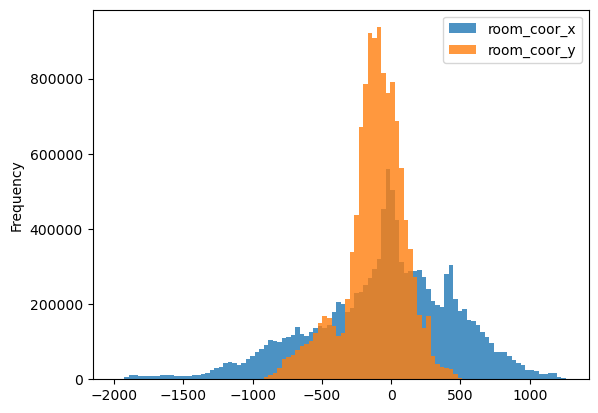

In [59]:
train[["room_coor_x", "room_coor_y"]].plot(kind="hist", bins=100, xlabel="room_coor", ylabel="count", alpha=0.8)

<AxesSubplot:ylabel='Frequency'>

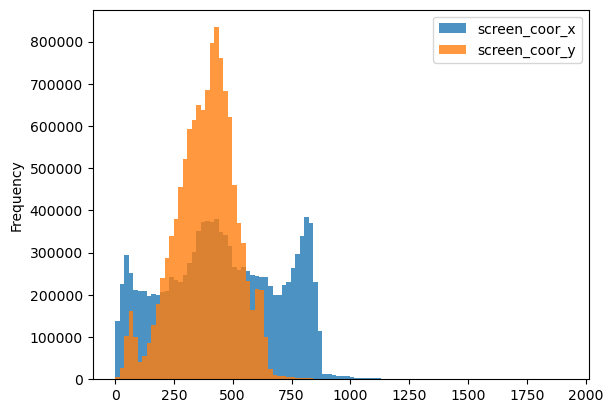

In [60]:
train[["screen_coor_x", "screen_coor_y"]].plot(kind="hist", bins=100, xlabel="screen_coor", ylabel="count", alpha=0.8)

In [61]:
s_id = 20090312431273200
train.query("session_id==@s_id")["room_fqid"].value_counts()

tunic.historicalsociety.entry              123
tunic.wildlife.center                      104
tunic.historicalsociety.cage                83
tunic.historicalsociety.frontdesk           73
tunic.library.frontdesk                     58
tunic.historicalsociety.basement            53
tunic.historicalsociety.closet_dirty        50
tunic.historicalsociety.closet              47
tunic.humanecology.frontdesk                44
tunic.historicalsociety.stacks              42
tunic.drycleaner.frontdesk                  33
tunic.kohlcenter.halloffame                 33
tunic.flaghouse.entry                       32
tunic.historicalsociety.collection          30
tunic.library.microfiche                    28
tunic.capitol_1.hall                        23
tunic.historicalsociety.collection_flag     12
tunic.capitol_0.hall                        11
tunic.capitol_2.hall                         2
Name: room_fqid, dtype: int64

In [62]:
train_labels["correct"].value_counts(normalize=True)

1    0.703946
0    0.296054
Name: correct, dtype: float64

## Count rows groupby session id

<AxesSubplot:ylabel='Frequency'>

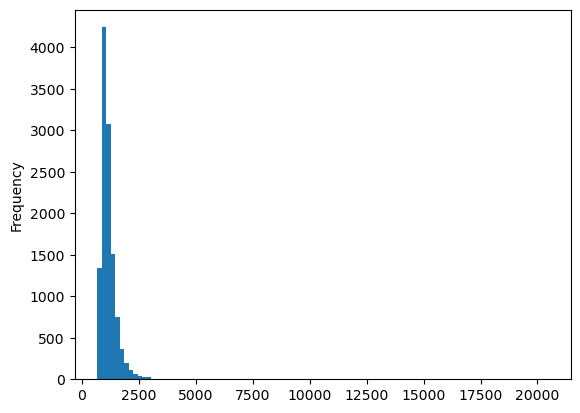

In [67]:
train.groupby("session_id")["index"].max().plot(kind="hist", bins=100, ylabel="count")

<AxesSubplot:xlabel='level', ylabel='count'>

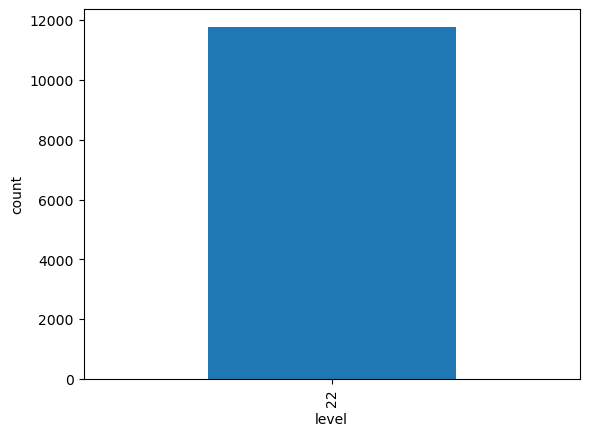

In [64]:
train.groupby("session_id")["level"].max().value_counts().sort_index().plot(kind="bar", xlabel="level", ylabel="count")

<AxesSubplot:xlabel='level', ylabel='count'>

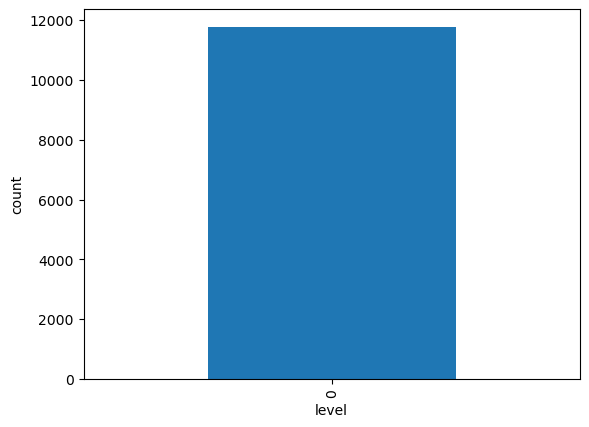

In [65]:

train.groupby("session_id")["level"].min().value_counts().sort_index().plot(kind="bar", xlabel="level", ylabel="count")